In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('consumer_durable.csv', index_col=['date'])
prices.head(10)

TITAN.NS  HAVELLS.NS   VOLTAS.NS  CROMPTON.NS  BATAINDIA.NS  \
date                                                                        
01-01-2018  852.450012  554.450012  648.950012   270.600006    755.299988   
02-01-2018  845.150024  549.250000  647.400024   277.799988    753.900024   
03-01-2018  856.299988  555.650024  643.599976   280.149994    772.400024   
04-01-2018  892.900024  562.849976  645.700012   282.950012    767.349976   
05-01-2018  909.700012  566.049988  646.349976   279.000000    764.799988   
08-01-2018  926.099976  563.099976  638.650024   273.950012    761.549988   
09-01-2018  932.950012  552.250000  648.599976   276.100006    746.900024   
10-01-2018  917.599976  549.700012  629.299988   270.500000    753.950012   
11-01-2018  906.900024  548.799988  625.849976   272.649994    749.700012   
12-01-2018  903.799988  549.099976  633.950012   272.250000    746.099976   

            KAJARIACER.NS  RAJESHEXPO.NS   RELAXO.NS  BLUESTARCO.NS  
date                                                                 
01-01-2018     725.099976     804.700012  343.424988     821.500000  
02-01-2018     712.950012     816.250000  335.450012     817.799988  
03-01-2018     736.950012     809.750000  343.000000     818.200012  
04-01-2018     743.700012     847.750000  340.200012     815.000000  
05-01-2018     750.849976     820.549988  339.774994     819.750000  
08-01-2018     748.150024     820.349976  336.875000     816.500000  
09-01-2018     753.000000     827.450012  337.274994     804.349976  
10-01-2018     747.599976     827.150024  339.950012     806.500000  
11-01-2018     742.000000     818.299988  337.600006     800.799988  
12-01-2018     739.549988     818.250000  339.024994     789.400024

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

TITAN.NS  HAVELLS.NS   VOLTAS.NS  CROMPTON.NS  BATAINDIA.NS  \
date                                                                         
01-01-2018   852.450012  554.450012  648.950012   270.600006    755.299988   
02-01-2018   845.150024  549.250000  647.400024   277.799988    753.900024   
30-12-2020  1552.599976  904.650024  819.799988   368.350006   1581.099976   
31-12-2020  1567.150024  916.150024  825.650024   380.549988   1579.650024   

            KAJARIACER.NS  RAJESHEXPO.NS   RELAXO.NS  BLUESTARCO.NS  
date                                                                 
01-01-2018     725.099976     804.700012  343.424988     821.500000  
02-01-2018     712.950012     816.250000  335.450012     817.799988  
30-12-2020     689.650024     486.799988  801.299988     801.549988  
31-12-2020     703.599976     490.549988  809.700012     801.099976

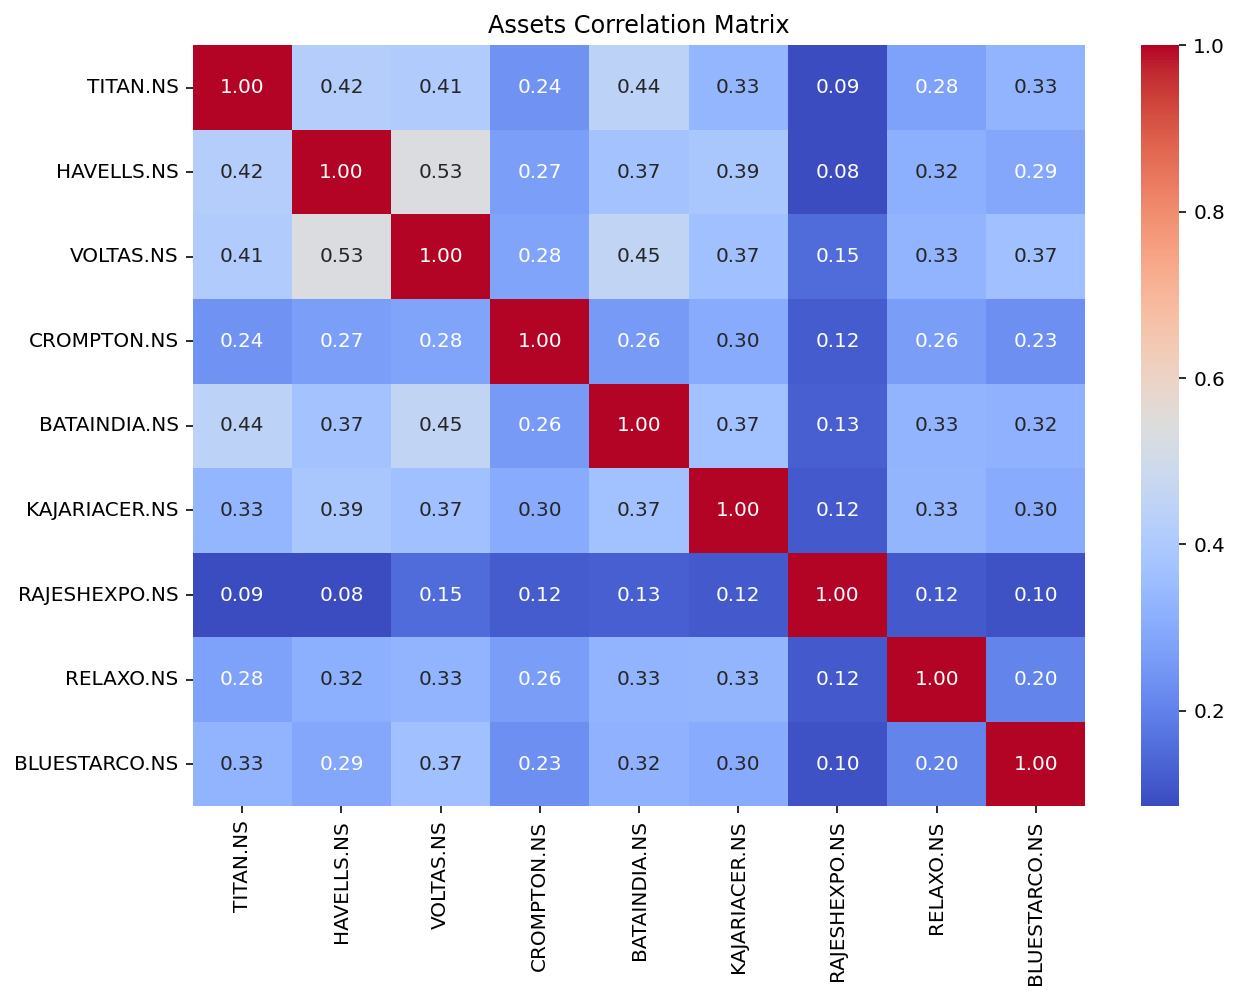

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('VOLTAS.NS', 'CROMPTON.NS')]


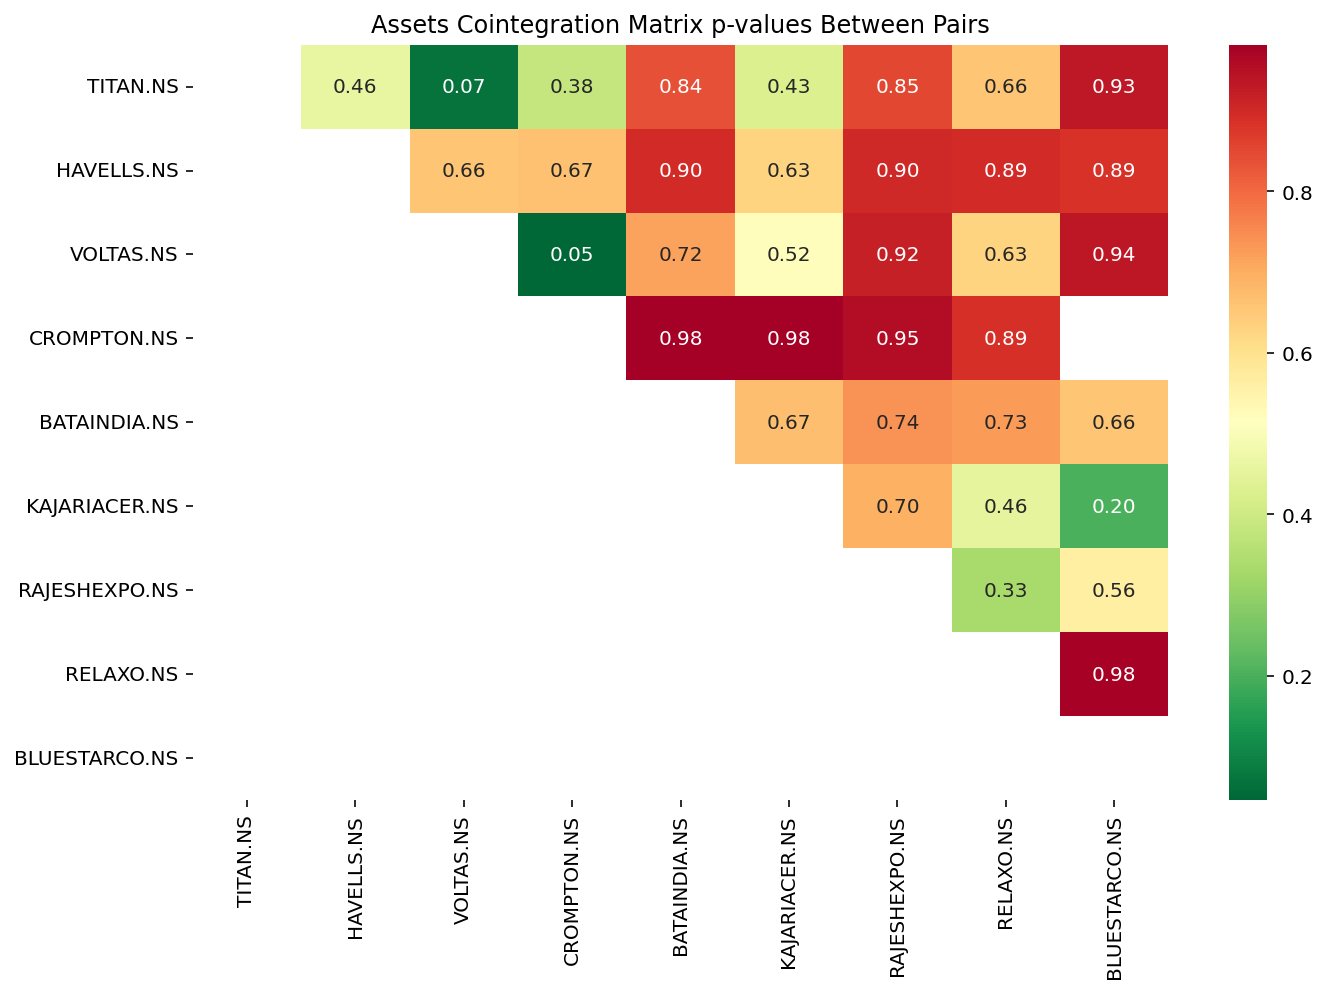

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'VOLTAS.NS'
asset2 = 'CROMPTON.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

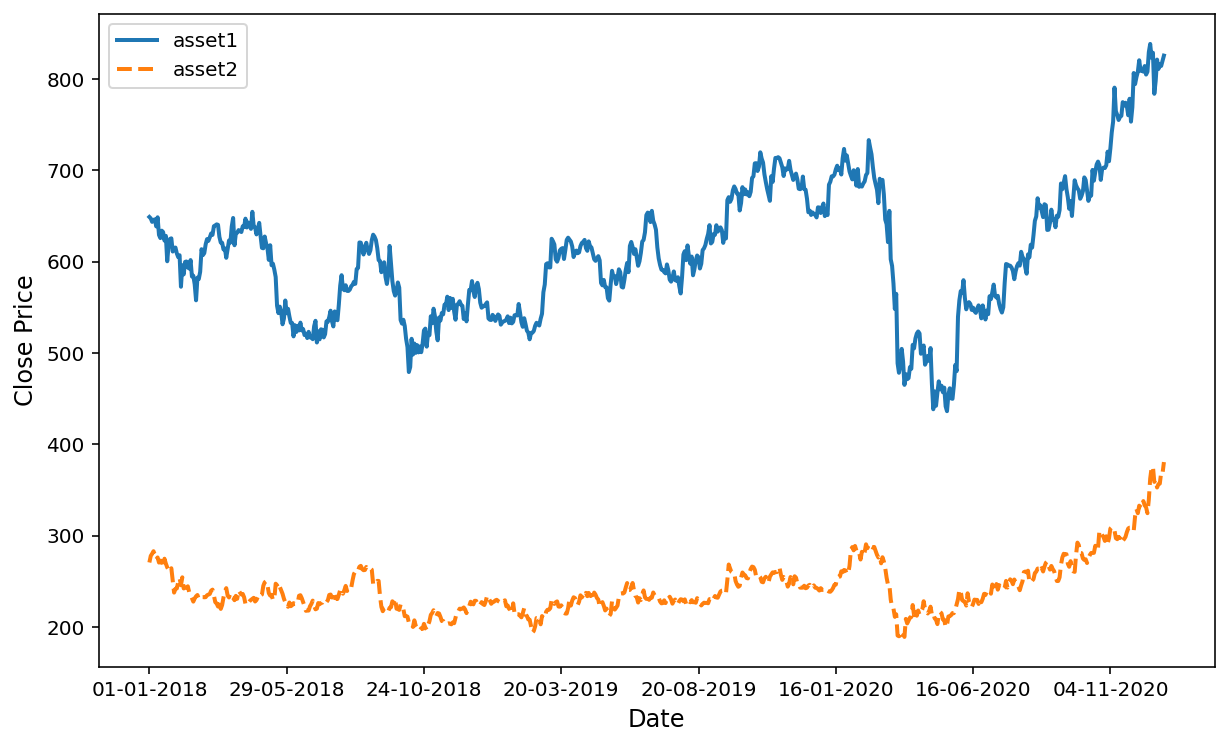

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1']].plot(figsize=(10, 6), linewidth=2,linestyle='solid', label = "asset1")
plt.plot(train[['asset2']], linewidth=2, linestyle='dashed', label = "asset2")
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
plt.legend()
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
#ax.grid(True);
plt.savefig('chart3', dpi=500) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.615e+05
Date:                Thu, 12 May 2022   Prob (F-statistic):                        0.00
Time:                        14:46:04   Log-Likelihood:                         -3124.3
No. Observations:                 740   AIC:                                      6251.
Df Residuals:                     739   BIC:                                      6255.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.3968      0.001    401.918      0.000       0.395       0.399
==============================================================================
Omnibus:                       16.403   Durbin-Watson:                   0.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.011
Skew:                           0.119   Prob(JB):                      0.00670
Kurtosis:                       2.482   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

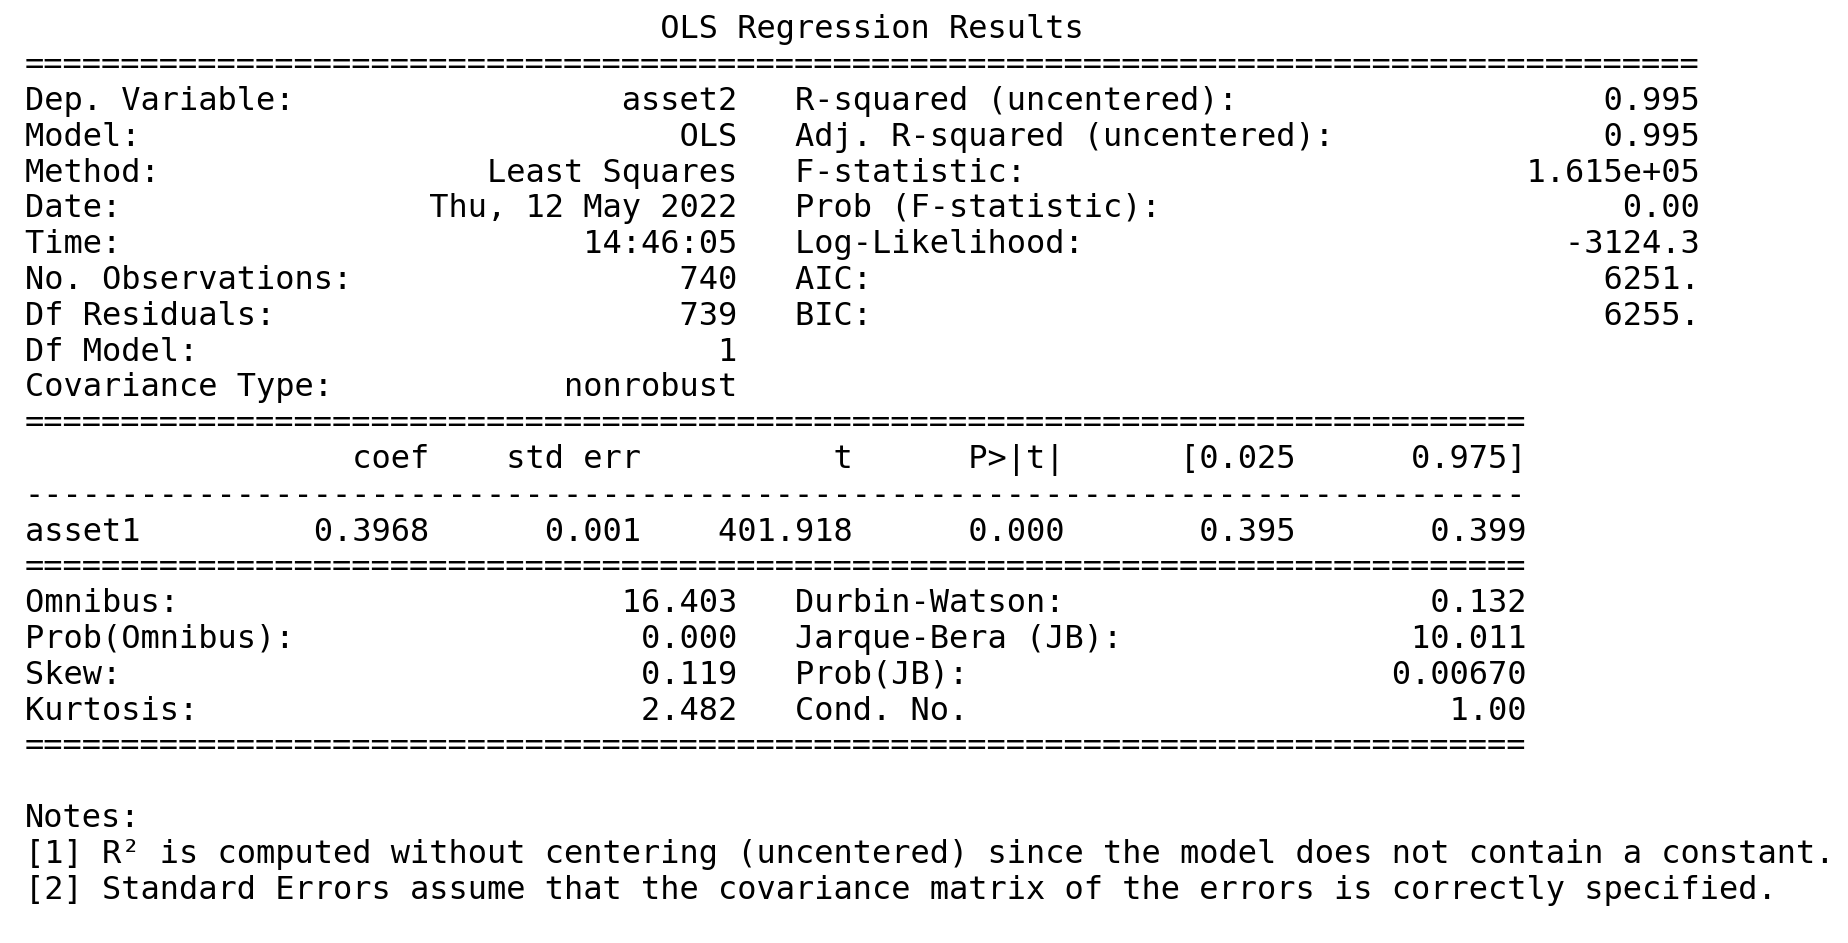

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.3967566679982259


In [18]:
# calculate spread
residual = train.asset2 - model.params[0] * train.asset1

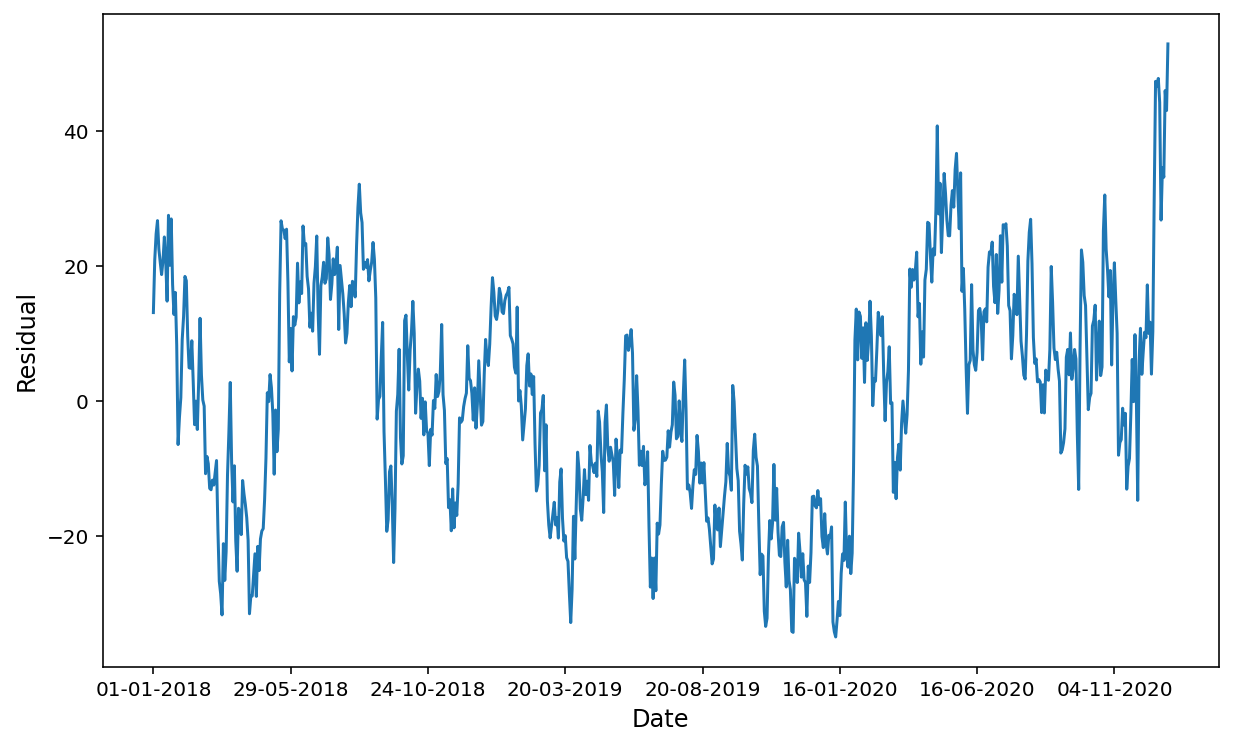

In [19]:
# Plot the residual
ax = residual.plot(figsize=(10, 6))
ax.set_ylabel("Residual", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.grid(True);
plt.savefig('chart5', dpi=500);

In [20]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-4.555057684770869,
 0.0001561829581139407,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 4722.968226638366)

In [21]:
print('Critical Value = ', adf[0])

Critical Value =  -4.555057684770869


In [22]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [24]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [25]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [26]:
signals.head()

asset1      asset2
date                              
01-01-2021  831.450012  378.049988
04-01-2021  846.000000  373.700012
05-01-2021  837.349976  377.350006
06-01-2021  869.299988  383.899994
07-01-2021  881.500000  395.049988

In [27]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [28]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  831.450012  378.049988 -1.476620            1.0           -1.0
04-01-2021  846.000000  373.700012 -1.169312            1.0           -1.0
05-01-2021  837.349976  377.350006 -1.382741            1.0           -1.0
06-01-2021  869.299988  383.899994 -1.166722            1.0           -1.0
07-01-2021  881.500000  395.049988 -1.323999            1.0           -1.0

In [29]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [30]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

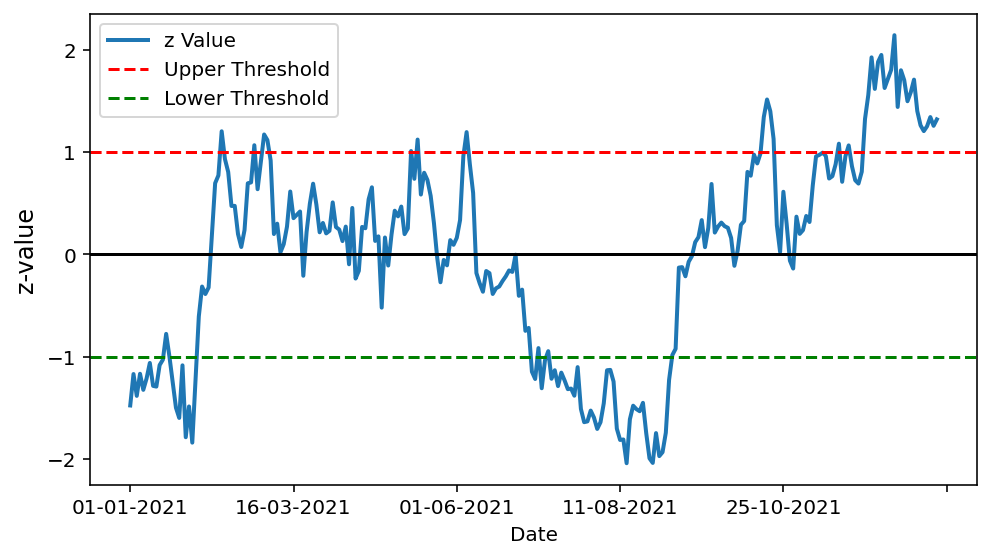

In [32]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value", figsize=(7, 4), linewidth=2)
#plt.title("Z-score Evaluation")
plt.ylabel("z-value", fontsize=12)
plt.xlabel("Date")
plt.axhline(signals['z'].mean(),linestyle= 'solid', color="black")
plt.axhline(signals['z upper limit'].mean(), linestyle= 'dashed',color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), linestyle = 'dashed', color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=500);

In [33]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   831.450012  378.049988 -1.476620            1.0           -1.0   
04-01-2021   846.000000  373.700012 -1.169312            1.0           -1.0   
05-01-2021   837.349976  377.350006 -1.382741            1.0           -1.0   
29-12-2021  1201.250000  430.299988  1.344032            1.0           -1.0   
30-12-2021  1198.800049  432.200012  1.258599            1.0           -1.0   
31-12-2021  1219.150024  437.450012  1.321604            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0

In [34]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  831.450012  378.049988 -1.476620            1.0           -1.0   
04-01-2021  846.000000  373.700012 -1.169312            1.0           -1.0   
05-01-2021  837.349976  377.350006 -1.382741            1.0           -1.0   
06-01-2021  869.299988  383.899994 -1.166722            1.0           -1.0   
07-01-2021  881.500000  395.049988 -1.323999            1.0           -1.0   
08-01-2021  902.200012  400.149994 -1.213089            1.0           -1.0   
11-01-2021  914.299988  399.850006 -1.060935            1.0           -1.0   
12-01-2021  903.200012  403.299988 -1.285139            1.0           -1.0   
13-01-2021  896.799988  400.700012 -1.291999            1.0           -1.0   
14-01-2021  912.200012  399.700012 -1.081867            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
13-01-2021         1         0.0        -1         0.0  
14-01-2021         1         0.0        -1         0.0

In [35]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   831.450012  378.049988 -1.476620            1.0           -1.0   
18-01-2021   890.900024  379.700012 -0.776564            1.0           -1.0   
20-01-2021   912.650024  405.950012 -1.243905            1.0           -1.0   
02-02-2021   987.849976  414.700012 -0.606294            1.0           -1.0   
11-02-2021  1103.199951  399.350006  1.205138            1.0           -1.0   
18-11-2021  1235.199951  451.299988  1.083678            1.0           -1.0   
22-11-2021  1185.400024  445.850006  0.711110            1.0           -1.0   
24-11-2021  1199.599976  438.850006  1.067135            1.0           -1.0   
25-11-2021  1201.349976  446.500000  0.862783            1.0           -1.0   
01-12-2021  1222.650024  438.549988  1.326321            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
18-01-2021         0        -1.0         0         1.0  
20-01-2021         1         1.0        -1        -1.0  
02-02-2021         0        -1.0         0         1.0  
11-02-2021        -1        -1.0         1         1.0  
18-11-2021        -1        -1.0         1         1.0  
22-11-2021         0         1.0         0        -1.0  
24-11-2021        -1        -1.0         1         1.0  
25-11-2021         0         1.0         0        -1.0  
01-12-2021        -1        -1.0         1         1.0

In [36]:
signals.loc[signals['positions1'] == 1].index

Index(['20-01-2021', '12-02-2021', '26-02-2021', '04-03-2021', '12-05-2021',
       '17-05-2021', '07-06-2021', '02-07-2021', '07-07-2021', '12-07-2021',
       '21-10-2021', '22-11-2021', '25-11-2021'],
      dtype='object', name='date')

In [37]:
signals['asset1'][signals['positions1'] == 1].value_counts()

912.650024     1
1079.199951    1
1018.150024    1
1072.500000    1
972.000000     1
983.650024     1
1096.800049    1
1013.900024    1
1005.500000    1
1017.400024    1
1192.050049    1
1185.400024    1
1201.349976    1
Name: asset1, dtype: int64

In [38]:
signals.loc[signals['positions1'] == -1].index

Index(['18-01-2021', '02-02-2021', '11-02-2021', '25-02-2021', '02-03-2021',
       '11-05-2021', '14-05-2021', '04-06-2021', '06-07-2021', '09-07-2021',
       '03-09-2021', '14-10-2021', '18-11-2021', '24-11-2021', '01-12-2021'],
      dtype='object', name='date')

In [39]:
signals.loc[signals['positions2'] == 1].index

Index(['18-01-2021', '02-02-2021', '11-02-2021', '25-02-2021', '02-03-2021',
       '11-05-2021', '14-05-2021', '04-06-2021', '06-07-2021', '09-07-2021',
       '03-09-2021', '14-10-2021', '18-11-2021', '24-11-2021', '01-12-2021'],
      dtype='object', name='date')

In [40]:
signals.loc[signals['positions2'] == -1].index

Index(['20-01-2021', '12-02-2021', '26-02-2021', '04-03-2021', '12-05-2021',
       '17-05-2021', '07-06-2021', '02-07-2021', '07-07-2021', '12-07-2021',
       '21-10-2021', '22-11-2021', '25-11-2021'],
      dtype='object', name='date')

In [41]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   831.450012  378.049988 -1.476620            1.0           -1.0   
04-01-2021   846.000000  373.700012 -1.169312            1.0           -1.0   
05-01-2021   837.349976  377.350006 -1.382741            1.0           -1.0   
06-01-2021   869.299988  383.899994 -1.166722            1.0           -1.0   
07-01-2021   881.500000  395.049988 -1.323999            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021  1195.750000  432.799988  1.206731            1.0           -1.0   
28-12-2021  1207.000000  435.299988  1.254240            1.0           -1.0   
29-12-2021  1201.250000  430.299988  1.344032            1.0           -1.0   
30-12-2021  1198.800049  432.200012  1.258599            1.0           -1.0   
31-12-2021  1219.150024  437.450012  1.321604            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0  

[248 rows x 9 columns]

In [42]:
signals = signals.reset_index()

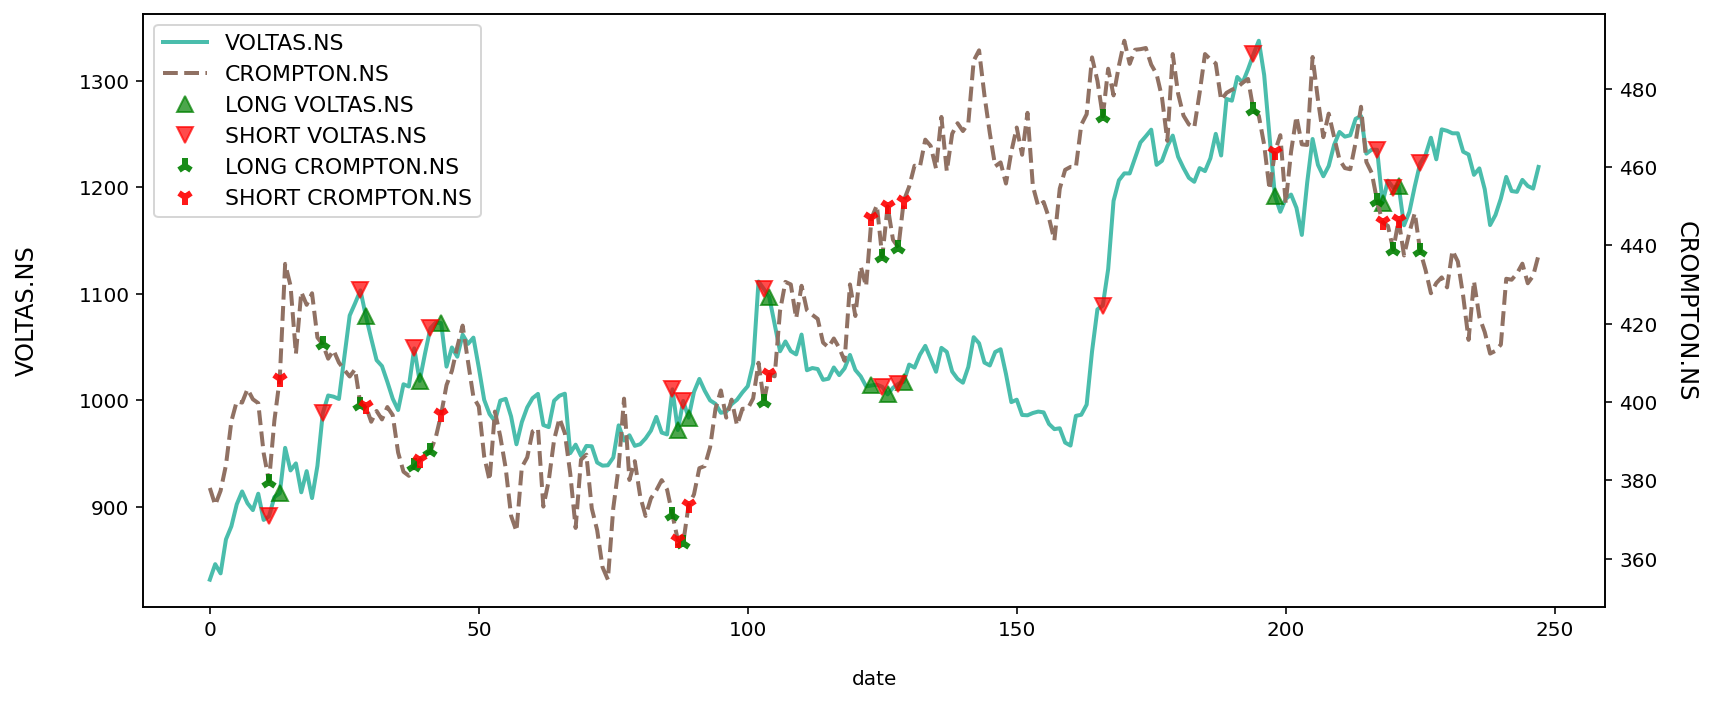

In [44]:
# visualize trading signals and position
fig=plt.figure(figsize=(12,5))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac', linestyle = 'solid', linewidth=2)
l2, = bx2.plot(signals['asset2'], c='#907163', linestyle = 'dashed', linewidth=2)

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, 
              marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,
              marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,
               marker='2',markersize=8, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,
               marker='1',markersize=8, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel(asset1,fontsize=12)
bx2.set_ylabel(asset2, rotation=270, fontsize=12)
bx.yaxis.labelpad=20
bx2.yaxis.labelpad=20
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best', fontsize = 11)

#plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date', fontsize=12)
#plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=500);

### Portfolio Profit and Loss Calculation

In [45]:
# initial capital to calculate the profit and loss
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [46]:
max(signals['asset1'])

1337.699951

In [47]:
max(signals['asset2'])

492.2000122

In [48]:
positions1

74.0

In [49]:
positions2

203.0

In [50]:
# since there are two assets, we calculate each asset's profit and loss separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [51]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0     831.450012            NaN            NaN            NaN       NaN   
1     846.000000       0.000000  100000.000000  100000.000000       NaN   
2     837.349976       0.000000  100000.000000  100000.000000  0.000000   
3     869.299988       0.000000  100000.000000  100000.000000  0.000000   
4     881.500000       0.000000  100000.000000  100000.000000  0.000000   
243  1195.750000 -176971.000000  289521.371051  112550.371051  0.000987   
244  1207.000000 -178636.000000  289521.371051  110885.371051 -0.014793   
245  1201.250000 -177785.000000  289521.371051  111736.371051  0.007675   
246  1198.800049 -177422.407252  289521.371051  112098.963799  0.003245   
247  1219.150024 -180434.203552  289521.371051  109087.167499 -0.026867   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [52]:
portfolio[portfolio.positions1 != 0].head()

asset1      holdings1          cash1  total asset1       return1  \
0    831.450012            NaN            NaN           NaN           NaN   
11   890.900024  -65926.601806  165926.601806  100000.00000 -1.110223e-16   
13   912.650024       0.000000   98390.500000   98390.50000 -2.700295e-03   
21   987.849976  -73100.898194  171491.398194   98390.50000  2.220446e-16   
28  1103.199951 -163273.592748  253128.194568   89854.60182 -9.906955e-03   

    positions1  
0          NaN  
11        -1.0  
13         1.0  
21        -1.0  
28        -1.0

In [53]:
portfolio.to_csv("portfolio_asset_1.csv")

In [54]:
# Profit and Loss for the second asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [55]:
portfolio.to_csv("portfolio_asset_2.csv")

In [56]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0     831.450012            NaN            NaN            NaN       NaN   
1     846.000000       0.000000  100000.000000  100000.000000       NaN   
2     837.349976       0.000000  100000.000000  100000.000000  0.000000   
3     869.299988       0.000000  100000.000000  100000.000000  0.000000   
4     881.500000       0.000000  100000.000000  100000.000000  0.000000   
243  1195.750000 -176971.000000  289521.371051  112550.371051  0.000987   
244  1207.000000 -178636.000000  289521.371051  110885.371051 -0.014793   
245  1201.250000 -177785.000000  289521.371051  111736.371051  0.007675   
246  1198.800049 -177422.407252  289521.371051  112098.963799  0.003245   
247  1219.150024 -180434.203552  289521.371051  109087.167499 -0.026867   

     positions1      asset2      holdings2      cash2   total asset2  \
0           NaN  378.049988            NaN        NaN            NaN   
1           0.0  373.700012       0.000000  100000.00  100000.000000   
2           0.0  377.350006       0.000000  100000.00  100000.000000   
3           0.0  383.899994       0.000000  100000.00  100000.000000   
4           0.0  395.049988       0.000000  100000.00  100000.000000   
243         0.0  432.799988  175716.795047  -65597.25  110119.545047   
244         0.0  435.299988  176731.795047  -65597.25  111134.545047   
245         0.0  430.299988  174701.795047  -65597.25  109104.545047   
246         0.0  432.200012  175473.204953  -65597.25  109875.954953   
247         0.0  437.450012  177604.704953  -65597.25  112007.454953   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.005934         0.0  
244  0.009217         0.0  
245 -0.018266         0.0  
246  0.007070         0.0  
247  0.019399         0.0

In [57]:
portfolio[portfolio.positions2 != 0]

asset1      holdings1          cash1   total asset1       return1  \
0     831.450012            NaN            NaN            NaN           NaN   
11    890.900024  -65926.601806  165926.601806  100000.000000 -1.110223e-16   
13    912.650024       0.000000   98390.500000   98390.500000 -2.700295e-03   
21    987.849976  -73100.898194  171491.398194   98390.500000  2.220446e-16   
28   1103.199951 -163273.592748  253128.194568   89854.601820 -9.906955e-03   
29   1079.199951  -79860.796374  173267.398194   93406.601820  3.953053e-02   
38   1048.699951 -155207.592748  250871.194568   95663.601820 -2.694659e-02   
39   1018.150024  -75343.101776  175528.092792  100184.991016  4.726342e-02   
41   1067.650024 -158012.203552  254534.194568   96521.991016 -1.795660e-02   
43   1072.500000  -79365.000000  175169.194568   95804.194568  6.955757e-04   
86   1010.250000 -149517.000000  249927.694568  100410.694568 -3.026617e-02   
87    972.000000  -71928.000000  177999.694568  106071.694568  5.637846e-02   
88    999.349976 -147903.796389  251951.592763  104047.796374 -1.908047e-02   
89    983.650024  -72790.101806  179161.490957  106371.389152  2.233197e-02   
103  1104.449951 -163458.592748  260890.787331   97432.194583  5.421780e-03   
104  1096.800049  -81163.203626  179727.583705   98564.380079  1.162024e-02   
123  1013.900024       0.000000  104698.981929  104698.981929 -6.357219e-04   
125  1012.599976  -74932.398224  179631.380153  104698.981929  0.000000e+00   
126  1005.500000       0.000000  105224.380153  105224.380153  5.018179e-03   
128  1015.400024  -75139.601776  180363.981929  105224.380153  0.000000e+00   
129  1017.400024       0.000000  105076.380153  105076.380153 -1.406518e-03   
166  1088.949951  -80582.296374  185658.676527  105076.380153  0.000000e+00   
194  1324.900024 -196085.203552  283701.278303   87616.074751 -1.168613e-02   
198  1192.050049  -88211.703626  195489.574677  107277.871051  8.299698e-02   
217  1235.199951 -182809.592748  286894.371051  104084.778303  1.777713e-04   
218  1185.400024  -87719.601776  199174.769275  111455.167499  7.081140e-02   
220  1199.599976 -177540.796448  287945.167499  110404.371051  4.511072e-03   
221  1201.349976  -88899.898224  199045.269275  110145.371051 -2.345922e-03   
225  1222.650024 -180952.203552  289521.371051  108569.167499 -1.454192e-02   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  378.049988            NaN            NaN            NaN   
11         -1.0  379.700012   77079.102477   22920.897523  100000.000000   
13          1.0  405.950012       0.000000  105328.750000  105328.750000   
21         -1.0  414.700012   84184.102477   21144.647523  105328.750000   
28         -1.0  399.350006  162136.102477  -59923.403715  102212.698762   
29          1.0  398.899994   80976.698762   21053.295047  102029.993809   
38         -1.0  383.600006  155741.602477  -56817.506191   98924.096285   
39          1.0  385.149994   78185.448762   21367.942570   99553.391332   
41         -1.0  387.399994  157284.397523  -57274.256191  100010.141332   
43          1.0  396.850006   80560.551238   23286.295047  103846.846285   
86         -1.0  371.149994  150686.897523  -52057.153715   98629.743809   
87          1.0  364.750000   74044.250000   21987.096285   96031.346285   
88         -1.0  364.000000  147784.000000  -51904.903715   95879.096285   
89          1.0  373.649994   75850.948762   23946.045047   99796.993809   
103        -1.0  400.049988  162420.295047  -57264.102477  105156.192570   
104         1.0  407.049988   82631.147523   25367.045047  107998.192570   
123         1.0  446.899994       0.000000  116087.743809  116087.743809   
125        -1.0  437.000000   88711.000000   27376.743809  116087.743809   
126         1.0  449.950012       0.000000  118716.596285  118716.596285   
128        -1.0  439.399994   89198.198762   29518.397523  118716.596285   
129         1.0  451.350006       0.000000 

In [58]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

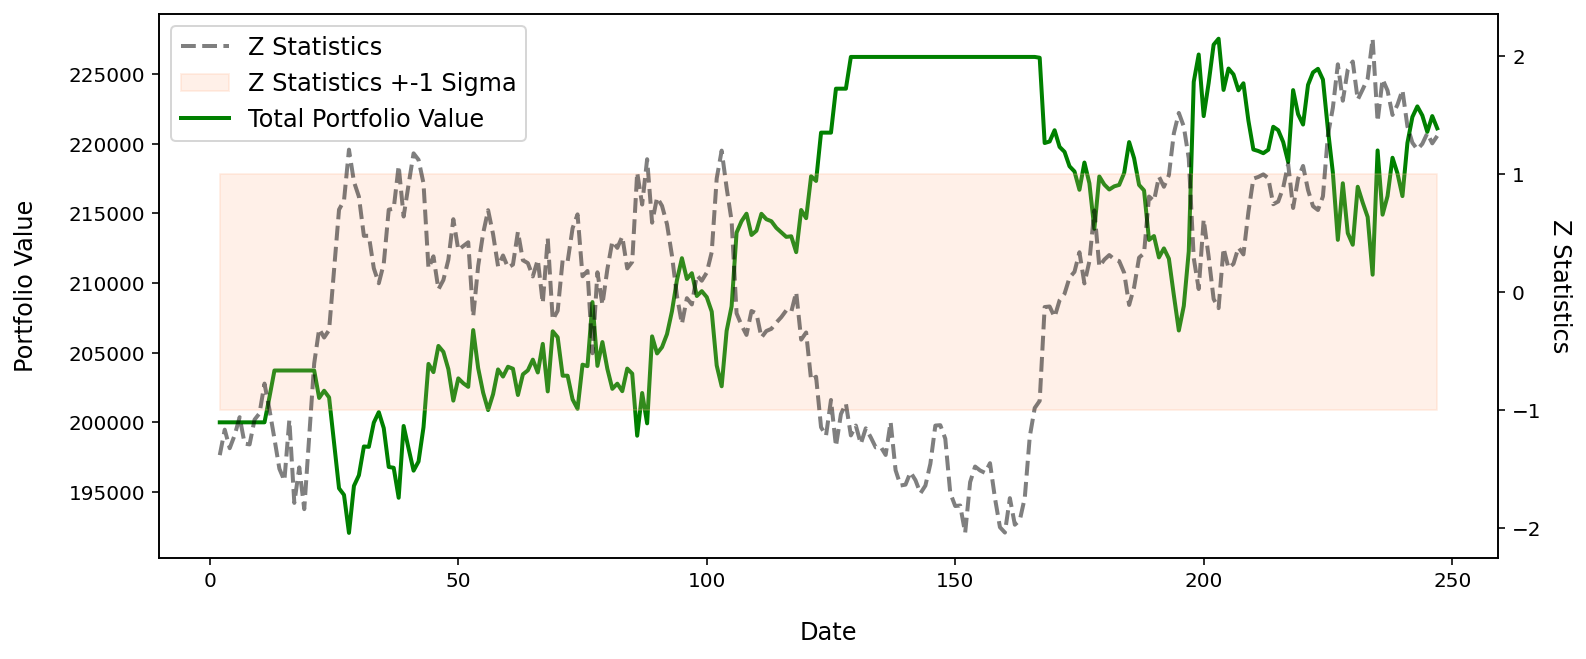

In [60]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(12,5),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g', linewidth = 2, linestyle='solid')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.5, linewidth = 2, 
               linestyle='dashed')

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value', fontsize=12)
ax2.set_ylabel('Z Statistics',rotation=270, fontsize=12)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.labelpad=15
#plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left', fontsize=12);
plt.savefig('chart8', dpi=500);

In [54]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

221094.62245240004

In [55]:
# Return on investment
profit = (final_portfolio - 2*initial_capital)

In [56]:
profit

21094.622452400043

In [57]:
roi = (profit/(2*initial_capital))*100

In [58]:
roi  # the overall ROI of the pair trading for the year 2021

10.547311226200021

In [59]:
portfolio.index[-1]

247

In [60]:
portfolio.index[0]

2

In [61]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [62]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 226.100%
